In [1]:
import numpy as np
import pandas as pd
import psycopg2
import getpass
# for configuring connection 
from configobj import ConfigObj
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = '192.168.60.144'
    conn_info["sqlport"] = 6432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == '192.168.60.144') & (conn_info["sqlport"]=='6432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: postgres


In [3]:
from sqlalchemy import create_engine,text

con = create_engine(
    f'postgresql://{conn_info["sqluser"]}:{conn_info["sqlpass"]}@{conn_info["sqlhost"]}:{conn_info["sqlport"]}/{conn_info["dbname"]}',
    connect_args={'options': '-c search_path=eicu_crd'}
)

In [4]:
def plot_counts(counts, title):
    # Create a DataFrame from the counts Series
    plt.figure(figsize=(12, 6))
    df_plot = pd.DataFrame({
         title: counts.index,
        "counts": counts.values
    })
    ax = sns.barplot(data=df_plot,
                        x=title,
                        y="counts",
                        palette="pastel",
                        hue=title,
                        dodge=False)
    
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}', 
                    xy=(p.get_x() + p.get_width() / 2, height),
                    xytext=(0, 9),
                    textcoords='offset points',
                    ha='center', va='bottom')
        
    plt.xticks(rotation=45, ha="right") 
    plt.show()

In [54]:
query =query_schema + """

SELECT distinct(l.*)
FROM labels AS l
INNER JOIN vitalp AS vp ON l.patient = vp.patient
WHERE l.unitdischargeoffset > 360

"""

df_an_6 = pd.read_sql_query(query,con)
print("there are {} patients in the  and {} records in flat".format(df_an_6['patient'].nunique(), df_an_6.shape[0]))

there are 3054 patients in the  and 3054 records in flat


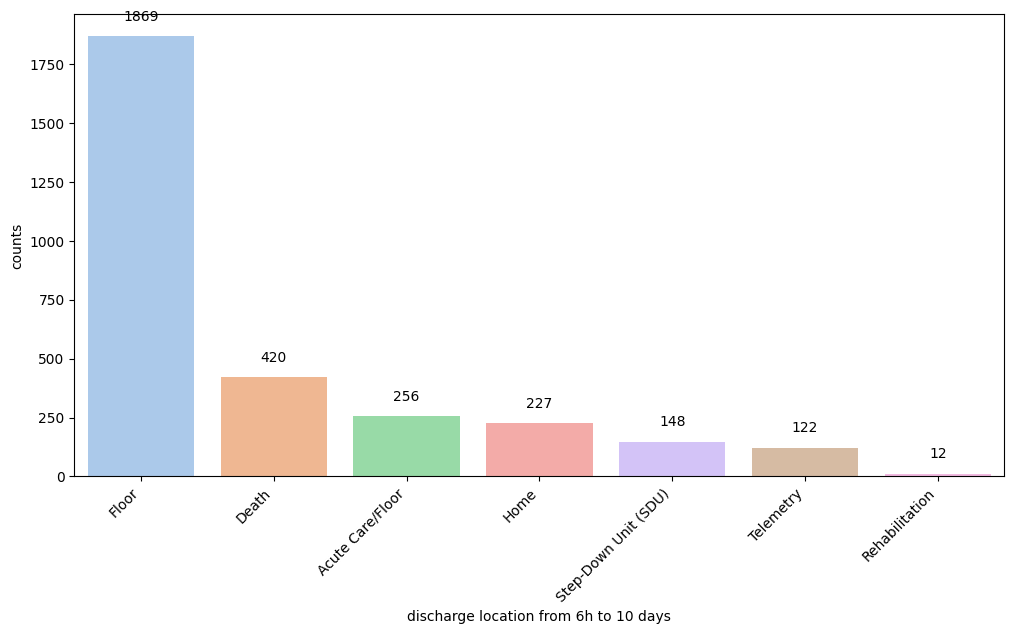

In [55]:
count_6 = df_an_6['unitdischargelocation'].value_counts()
plot_counts(count_6, 'discharge location from 6h to 10 days')

In [56]:
query =query_schema + """

SELECT distinct(l.*)
FROM labels AS l
INNER JOIN vitalp AS vp ON l.patient = vp.patient
WHERE l.unitdischargeoffset > 720

"""

df_an_12 = pd.read_sql_query(query,con)
print("there are {} patients in the  and {} records in flat".format(df_an_12['patient'].nunique(), df_an_12.shape[0]))

there are 3006 patients in the  and 3006 records in flat


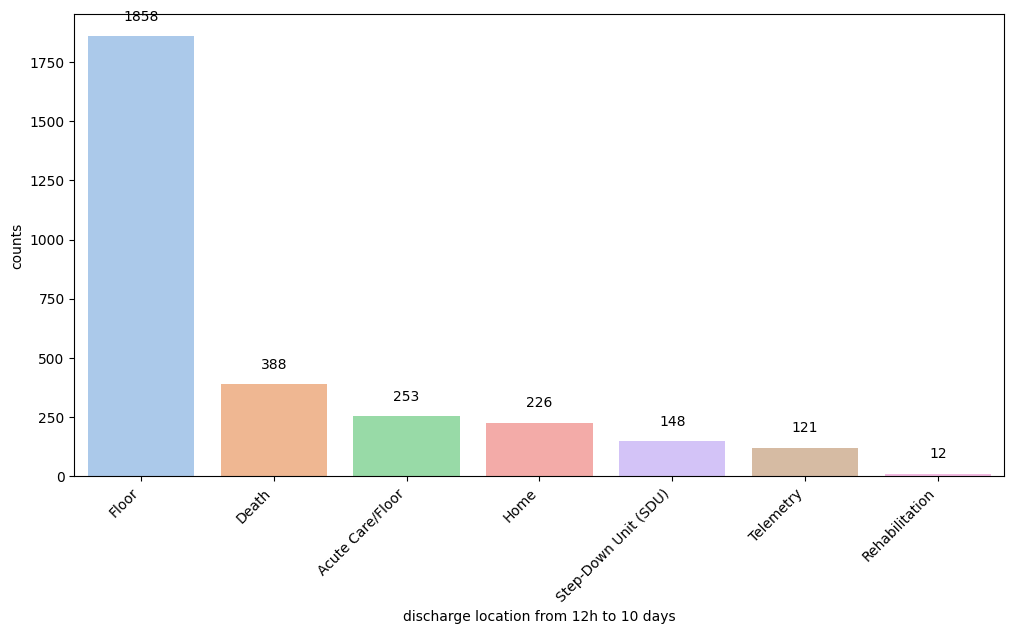

In [57]:
count_12 = df_an_12['unitdischargelocation'].value_counts()
plot_counts(count_12, 'discharge location from 12h to 10 days')

In [24]:
hdf= '/home/mei/nas/docker/thesis/data/hdf/'
drug = pd.read_hdf(hdf+'final_flat_drug.h5', key='df')
diagnosis = pd.read_hdf(hdf+'final_diagnoses_trim_level.h5', key='df')
ts= pd.read_hdf(hdf+'final_timeseries_60min.h5', key='df')


In [21]:
# show the selected patient with valid value.
id= 2754168
drug_patient = drug[drug['patient'] == id]
mask = drug_patient.iloc[0].notna() & (drug_patient.iloc[0] != 0)
drug_patient_nonzero = drug_patient.loc[:, mask]
display(drug_patient_nonzero)

,patient,gender,age,admissionweight,allopurinol,aspirin,hydralazine_hcl,lasix,lipitor,losartan_potassium,multivitamin
1911,2754168,1,0.914286,0.163544,1,1,1,1,1,1,1


In [25]:
diagnosis_patient = diagnosis[diagnosis['patient'] == id]
mask = diagnosis_patient.iloc[0].notna() & (diagnosis_patient.iloc[0] != 0)
diagnosis_patient_nonzero = diagnosis_patient.loc[:, mask]
display(diagnosis_patient_nonzero)

,patient,diagnosisstring,first,second
316194,2754168,Cardiovascular (R)/Hypertension Requiring Tre...,Cardiovascular (R),Hypertension Requiring Treatment


In [23]:
ts_patient = ts.loc[id]
mask = ts_patient.iloc[0].notna() & (ts_patient.iloc[0] != 0)
ts_patient_nonzero = ts_patient.loc[:, mask]
display(ts_patient_nonzero)

,-bands,-eos,-lymphs,-monos,-polys,24 h urine protein,24 h urine urea nitrogen,ALT (SGPT),ANF/ANA,AST (SGOT),...,sao2,heartrate,respiration,cvp,systemicsystolic,systemicdiastolic,systemicmean,st1,st2,st3
time,,,,,,,,,,,,,,,,,,,,,
1,0.5,0.097737,0.103050,0.251984,0.837163,0.5,0.5,0.003001,0.5,0.001027,...,0.974104,0.325284,0.328063,0.583819,0.5,0.5,0.5,0.026819,0.019175,0.014328
2,0.5,0.102881,0.104139,0.253968,0.834597,0.5,0.5,0.003022,0.5,0.001043,...,0.975111,0.322673,0.326218,0.579828,0.5,0.5,0.5,0.026762,0.019196,0.014391
3,0.5,0.108025,0.105229,0.255952,0.832030,0.5,0.5,0.003043,0.5,0.001059,...,0.976242,0.321264,0.325112,0.576957,0.5,0.5,0.5,0.026717,0.019225,0.014451
4,0.5,0.113169,0.106318,0.257937,0.829464,0.5,0.5,0.003064,0.5,0.001075,...,0.977275,0.320073,0.324034,0.575423,0.5,0.5,0.5,0.026674,0.019247,0.014507
5,0.5,0.118313,0.107407,0.259921,0.826897,0.5,0.5,0.003086,0.5,0.001091,...,0.977527,0.320534,0.323111,0.577662,0.5,0.5,0.5,0.026638,0.019222,0.014518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0.5,0.111111,0.117647,0.285714,0.811301,0.5,0.5,0.005791,0.5,0.003130,...,0.957143,0.425439,0.452830,0.433333,0.5,0.5,0.5,0.028637,0.024094,0.017279
99,0.5,0.111111,0.117647,0.285714,0.811301,0.5,0.5,0.005791,0.5,0.003130,...,0.957143,0.425439,0.452830,0.433333,0.5,0.5,0.5,0.028637,0.024094,0.017279
100,0.5,0.111111,0.117647,0.285714,0.811301,0.5,0.5,0.005791,0.5,0.003130,...,0.957143,0.425439,0.452830,0.433333,0.5,0.5,0.5,0.028637,0.024094,0.017279


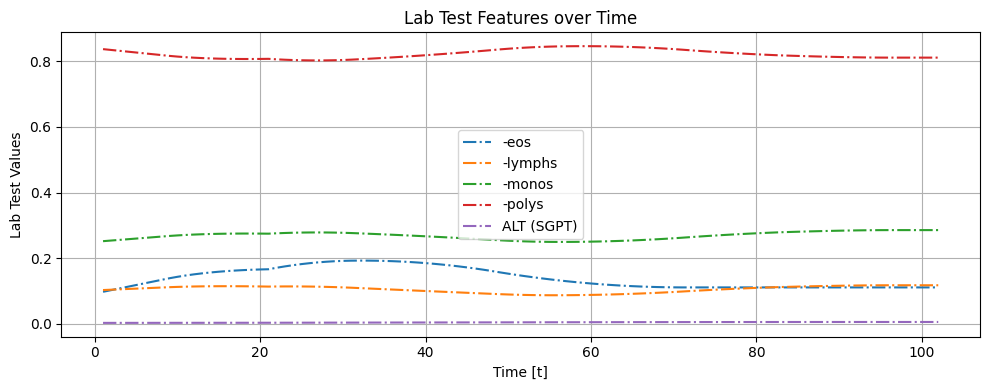

In [35]:
time = ts_patient_nonzero.index

# Lab test features
lab_features = ['-eos', '-lymphs', '-monos', '-polys', 'ALT (SGPT)']

# Plot Lab Tests
plt.figure(figsize=(10, 4))
for feature in lab_features:
    plt.plot(time, ts_patient_nonzero[feature], label=feature,linestyle='dashdot')

plt.xlabel("Time [t]")
plt.ylabel("Lab Test Values")
plt.title("Lab Test Features over Time")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

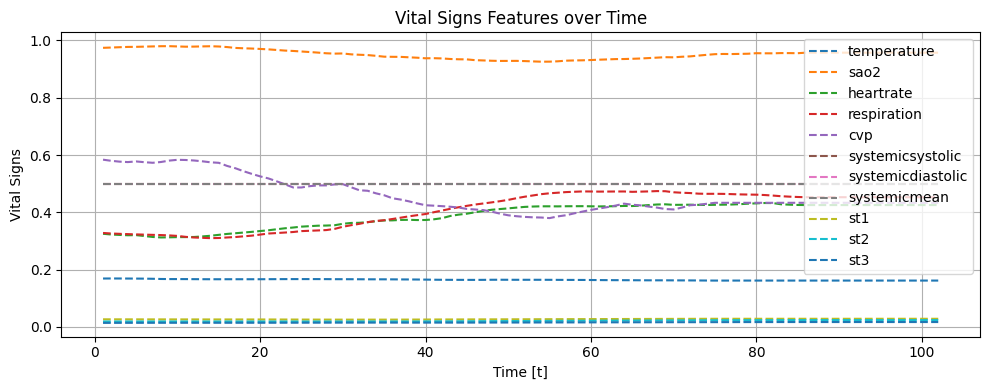

In [37]:
vital_features = ts_patient_nonzero.columns[-11:]

# Plot Vital Signs
plt.figure(figsize=(10,4))
for feature in vital_features:
    plt.plot(time, ts_patient_nonzero[feature], label=feature, linestyle='--')

plt.xlabel("Time [t]")
plt.ylabel("Vital Signs")
plt.title("Vital Signs Features over Time")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()